<a href="https://colab.research.google.com/github/treasure-data/td-notebooks/blob/master/machine-learning/churn/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

This notebook shows how to classify churn users with Logistic Regression in Hivemall.  
As for the dataset, please refer [this article](https://aws.amazon.com/blogs/machine-learning/predicting-customer-churn-with-amazon-machine-learning/)  

# SetUp

Executing a following cell, you are asked to input some information.

In [0]:
from getpass import getpass
td_api_key = getpass('Enter TD API KEY here ')
database   = input('Enter YOUR DATABASE to create tables here ')
assert database, "Error: Input YOUR DATABASE"
endpoint   = input('Enter YOUR ENDPOINT to create tables here (default: "api.treasuredata.com") \nref : https://support.treasuredata.com/hc/en-us/articles/360001474288-Sites-and-Endpoints ')
endpoint = endpoint if endpoint else 'https://api.treasuredata.com/'
endpoint = 'https://' + endpoint if not endpoint.startswith('https://') else endpoint
use_spark  = input('If enable to use spark, enter "true" (default: false) ').lower()
use_spark  = use_spark == 'true'
table = 'churn_dataset'

Enter TD API KEY here ··········
Enter YOUR DATABASE to create tables here hivemall
Enter YOUR ENDPOINT to create tables here (default: "api.treasuredata.com") 
ref : https://support.treasuredata.com/hc/en-us/articles/360001474288-Sites-and-Endpoints 
If enable to use spark, enter "true" (default: false) 


In [0]:
%%capture
!pip install td-client
!pip install pandas-td
!pip install -q git+https://github.com/takuti/pytd@master#egg=treasure-data[spark]

import numpy as np
import pandas as pd
import pandas_td as td
import matplotlib.pyplot as plt
import seaborn as sns
import pytd
import tdclient
pd.options.display.max_columns = 30

%matplotlib inline
con = td.connect(apikey=td_api_key, endpoint=endpoint)
c = tdclient.Client(apikey=td_api_key, endpoint=endpoint)
presto = td.create_engine('presto:{}'.format(database), con=con)
hive = td.create_engine('hive:{}'.format(database), con=con)

def recreate_table(client, table, database=database):
  if table in [table.name for table in client.tables(database)]:
    client.delete_table(database, table)
  client.create_log_table(database, table)
  return None

# Data Preparation

A cell below will create a table on your Treasure Data account.  
This cell takes a little long time (5min.)

In [0]:
%%capture
!wget http://dataminingconsultant.com/DKD2e_data_sets.zip
!unzip -o DKD2e_data_sets.zip

In [0]:
df = pd.read_csv('./Data sets/churn.txt')
df.columns = ['state','account_length','area_code','phone','intl_plan','vmail_plan','vmail_message','day_mins','day_calls','day_charge','eve_mins','eve_calls','eve_charge','night_mins','night_calls','night_charge','intl_mins','intl_calls','intl_charge','cust_serv_calls','is_churn']

In [0]:
if use_spark:
  client = pytd.Client(database=database, apikey=td_api_key)
  client.load_table_from_dataframe(df.reset_index(), '{}.{}'.format(database, table), if_exists='overwrite')
else:
  if table in [table.name for table in c.tables(database)]:
    c.delete_table(database, table)
  td.to_td(df, '{}.{}'.format(database, table), con)

Check the table

In [0]:
td.read_td_query('''
select
  is_churn,state,account_length,area_code,phone,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,cust_serv_calls
from
  churn_dataset
limit 2
''', engine=presto)

,is_churn,state,account_length,area_code,phone,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,cust_serv_calls
0,False.,WI,93,415,392-6286,no,no,0,152.1,141,25.86,215.5,107,18.32,262.4,111,11.81,12.0,7,3.24,1
1,False.,OK,149,510,365-9079,yes,no,0,180.9,79,30.75,194.9,83,16.57,197.8,109,8.90,8.8,9,2.38,3


**Columns**
- state: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- account_length: the number of days that this account has been active
- area_code: the three-digit area code of the corresponding customer’s phone number
- phone: the remaining seven-digit phone number
- intl_plan: whether the customer has an international calling plan: yes/no
- vmail_plan: whether the customer has a voice mail feature: yes/no
- vmail_message: presumably the average number of voice mail messages per month
- day_mins: the total number of calling minutes used during the day
- day_calls: the total number of calls placed during the day
- day_charge: the billed cost of daytime calls
- eve_mins, eve_calls, eve_charge: the billed cost for calls placed during the evening
- night_mins, night_calls, night_charge: the billed cost for calls placed during nighttime
- intl_mins, intl_calls, intl_charge: the billed cost for international calls
- cust_serv_calls: the number of calls placed to Customer Service
- is_churn: whether the customer left the service: true/false

# EDA (Explore Data Analysis)
Before running machine learning tasks, you should understand your data correctly.  
Descriptive statistics and visualization are important for this.

## Data Size

In [0]:
td.read_td_query('''
select
  count(*)
from
  churn_dataset
''', engine=presto)

,_col0
0,3333


## Check if null value exists

In [0]:
td.read_td_query('''
select
  count(is_churn) as is_churn,
  count(state) as state,
  count(account_length) as account_length,
  count(area_code) as area_code,
  count(phone) as phone,
  count(intl_plan) as intl_plan,
  count(vmail_plan) as vmail_plan,
  count(vmail_message) as vmail_message,
  count(day_mins) as day_mins,
  count(day_calls) as day_calls,
  count(day_charge) as day_charge,
  count(eve_mins) as eve_mins,
  count(eve_calls) as eve_calls,
  count(eve_charge) as eve_charge,
  count(night_mins) as night_mins,
  count(night_calls) as night_calls,
  count(night_charge) as night_charge,
  count(intl_mins) as intl_mins,
  count(intl_calls) as intl_calls,
  count(intl_charge) as intl_charge,
  count(cust_serv_calls) as cust_serv_calls
from
  churn_dataset
''', engine=presto)

,is_churn,state,account_length,area_code,phone,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,cust_serv_calls
0,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333


Null value is not found.

## Target Variable

In [0]:
td.read_td_query('''
select
  is_churn
  ,count(*) as n
from
  churn_dataset
group by
  1
''', engine=presto)

,is_churn,n
0,False.,2850
1,True.,483


## state(string)

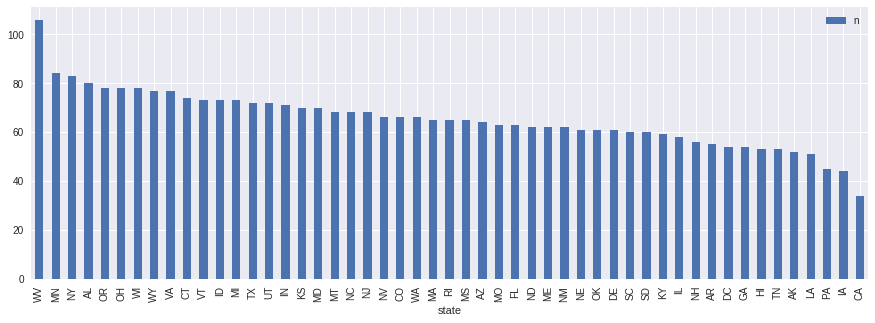

In [0]:
td.read_td_query('''
select
  state
  ,count(*) as n
from
  churn_dataset
group by
  1
order by
  2 desc
''', engine=presto, index_col='state').plot.bar(figsize=(15,5))

## account_length (int)

In [0]:
td.read_td_query('''
select
  avg(account_length) as average
  ,min(account_length) as min
  ,approx_percentile(account_length, 0.25) as pct_25th
  ,approx_percentile(account_length, 0.50) as pct_50th
  ,approx_percentile(account_length, 0.75) as pct_75th
  ,max(account_length) as max
from
  churn_dataset
''', engine=presto)

,average,min,pct_25th,pct_50th,pct_75th,max
0,101.064806,1,74,101,127,243


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa25681ae10>]],
      dtype=object)

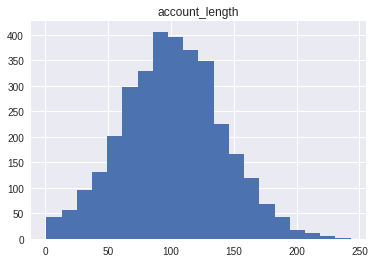

In [0]:
td.read_td_query('''
  select
    account_length
  from
    churn_dataset
''', engine=presto).hist(bins=20)

## area_code (string)

In [0]:
td.read_td_query('''
select
  area_code
  ,count(*) as n
from
  churn_dataset
group by
  1
order by
  2 desc
''', engine=presto)

,area_code,n
0,415,1655
1,510,840
2,408,838


## phone(string)
This column is unique for each row. So, this cannot be used for machine learning.

In [0]:
td.read_td_query('''
select
  count(phone) as n
  ,count(distinct phone) as n_unique
from
  churn_dataset
''', engine=presto)

,n,n_unique
0,3333,3333


## intl_plan(string)

In [0]:
td.read_td_query('''
select
  intl_plan
  ,count(*) as n
from
  churn_dataset
group by
  1
order by
  2 desc
''', engine=presto)

,intl_plan,n
0,no,3010
1,yes,323


## vmail_plan(string)

In [0]:
td.read_td_query('''
select
  vmail_plan
  ,count(*) as n
from
  churn_dataset
group by
  1
order by
  2 desc
''', engine=presto)

,vmail_plan,n
0,no,2411
1,yes,922


## vmail_message(int)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4c3bf0358>]],
      dtype=object)

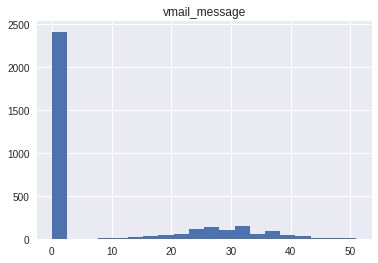

In [0]:
td.read_td_query('''
select
  vmail_message
from
  churn_dataset
''', engine=presto).hist(bins=20)

## day_mins(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4c3ab2dd8>]],
      dtype=object)

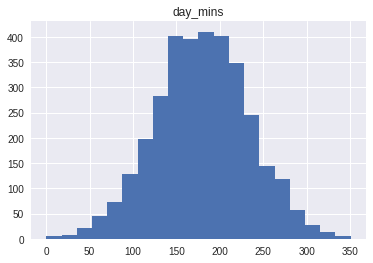

In [0]:
td.read_td_query('''
select
  day_mins
from
  churn_dataset
''', engine=presto).hist(bins=20)

## day_calls(int)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4c1220668>]],
      dtype=object)

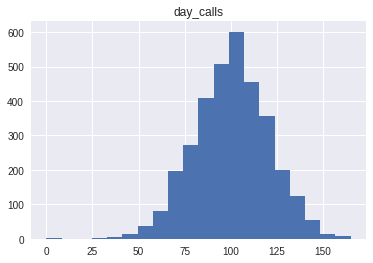

In [0]:
td.read_td_query('''
select
  day_calls
from
  churn_dataset
''', engine=presto).hist(bins=20)

## day_charge(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4c12272e8>]],
      dtype=object)

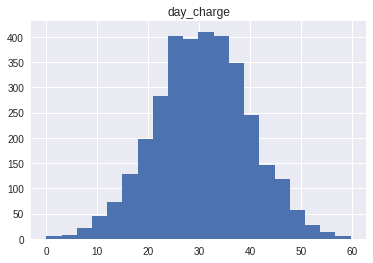

In [0]:
td.read_td_query('''
select
  day_charge
from
  churn_dataset
''', engine=presto).hist(bins=20)

## eve_mins(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4c12321d0>]],
      dtype=object)

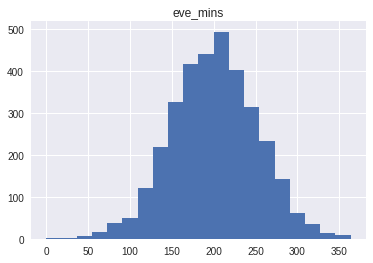

In [0]:
td.read_td_query('''
select
  eve_mins
from
  churn_dataset
''', engine=presto).hist(bins=20)

## eve_calls(int)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4c10c12e8>]],
      dtype=object)

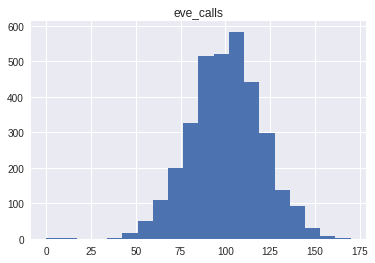

In [0]:
td.read_td_query('''
select
  eve_calls
from
  churn_dataset
''', engine=presto).hist(bins=20)

## eve_charge(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4c0fe8c88>]],
      dtype=object)

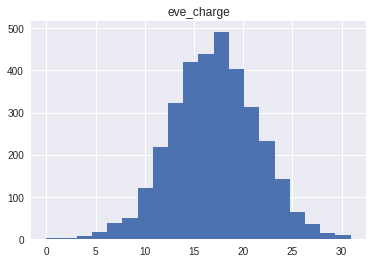

In [0]:
td.read_td_query('''
select
  eve_charge
from
  churn_dataset
''', engine=presto).hist(bins=20)

## night_mins(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4c0fb6d68>]],
      dtype=object)

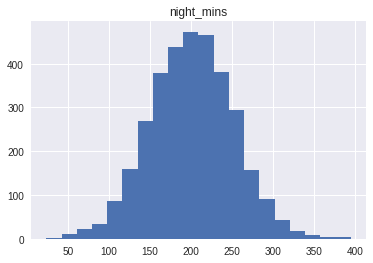

In [0]:
td.read_td_query('''
select
  night_mins
from
  churn_dataset
''', engine=presto).hist(bins=20)

## night_calls(int)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4c10b5da0>]],
      dtype=object)

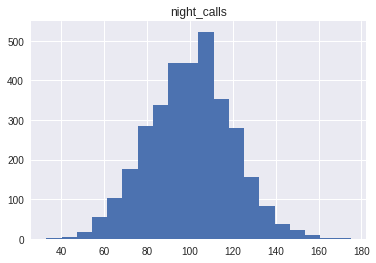

In [0]:
td.read_td_query('''
select
  night_calls
from
  churn_dataset
''', engine=presto).hist(bins=20)

## night_charge(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4c0e61048>]],
      dtype=object)

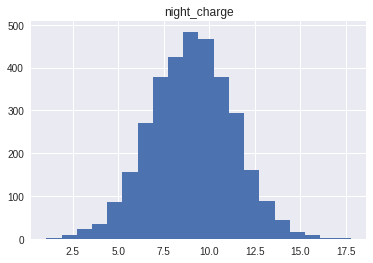

In [0]:
td.read_td_query('''
select
  night_charge
from
  churn_dataset
''', engine=presto).hist(bins=20)

## intl_mins(double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4c3c0df28>]],
      dtype=object)

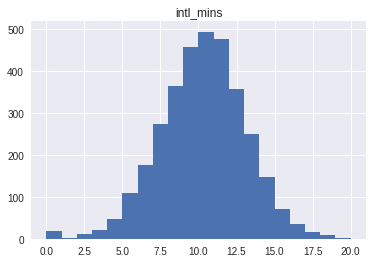

In [0]:
td.read_td_query('''
select
  intl_mins
from
  churn_dataset
''', engine=presto).hist(bins=20)

## intl_calls(int)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4c0d6c0f0>]],
      dtype=object)

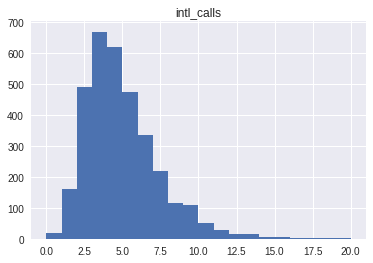

In [0]:
td.read_td_query('''
select
  intl_calls
from
  churn_dataset
''', engine=presto).hist(bins=20)

## intl_charge (double)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff4c0c87e48>]],
      dtype=object)

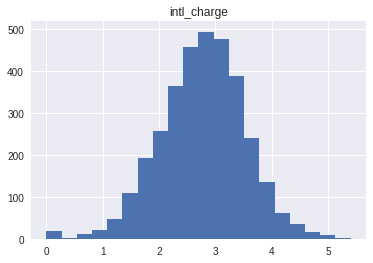

In [0]:
td.read_td_query('''
select
  intl_charge
from
  churn_dataset
''', engine=presto).hist(bins=20)

## cust_serv_calls

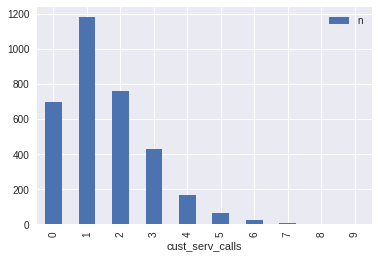

In [0]:
td.read_td_query('''
select
  cust_serv_calls
  ,count(*) as n
from
  churn_dataset
group by
  1
''', engine=presto, index_col='cust_serv_calls').sort_index().plot.bar()

## Correlations
With python library, you can visuazlie the relashionship between variables.

In [0]:
df = td.read_td_query('''
  select
    case when is_churn like 'True.' then 1 else 0 end as is_churn
    ,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,cust_serv_calls
  from
    churn_dataset    
''', engine=presto)

### Scatter plot

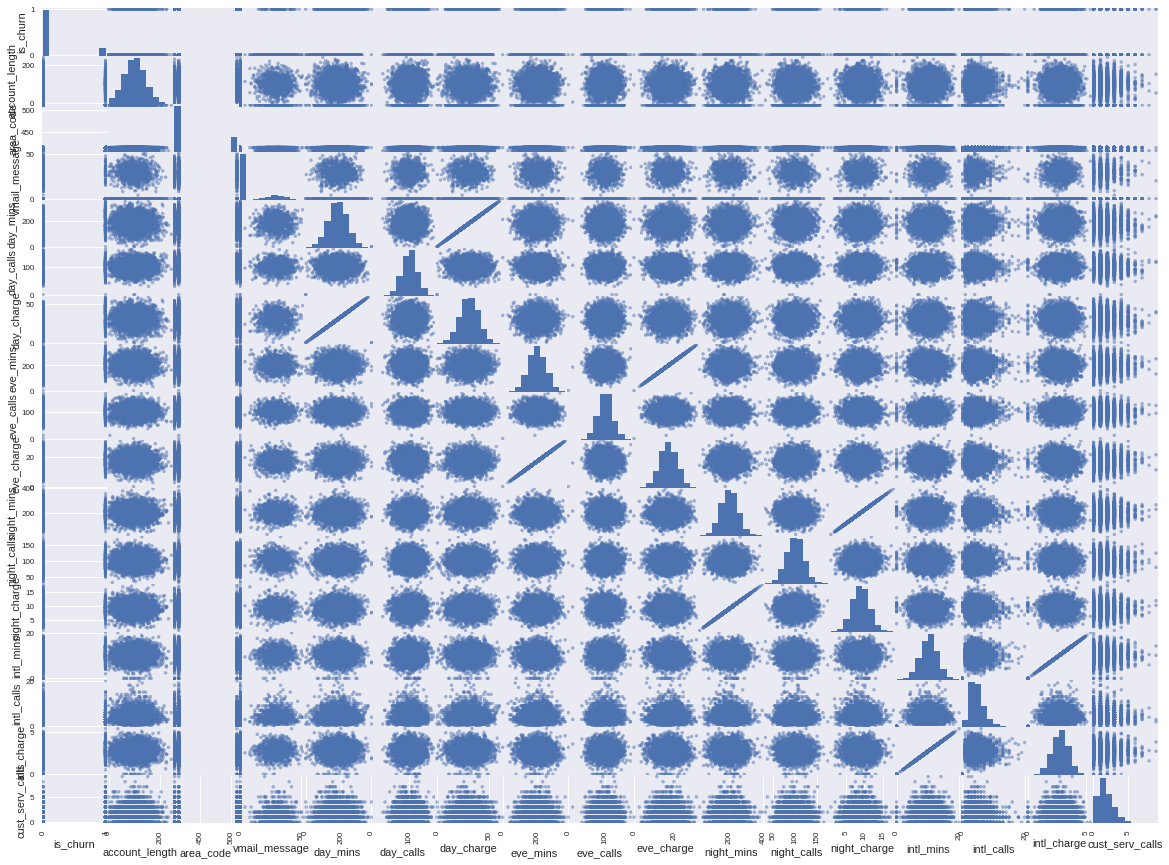

In [0]:
pd.plotting.scatter_matrix(df, figsize=(20,15))
plt.show()

### Correlatiion coefficient matrix

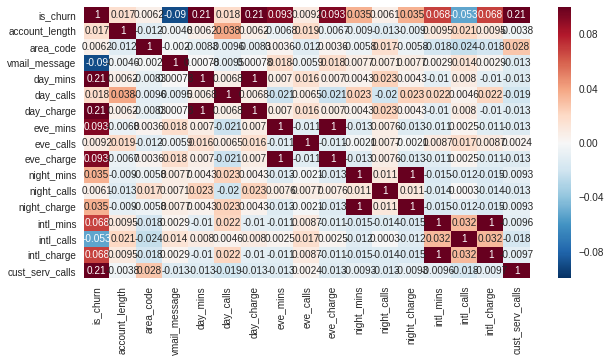

In [0]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(df.corr(), annot=True, ax=ax, vmin=-0.1, vmax=0.1)
plt.show()

The correlation coefficients of pairs (day_mins, day_charge) , (eve_mins, eve_charge), (intl_mins, intl_charge) equals `1.0`.  
You should remove one of elements from feature variables because of [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity).

# Run a machine learning task

## WIthout rescaling
At first, let's build a model not having features rescale.

### Preprocess

- Data is splitted into training data and test data. The number of rows for each `state` coliumns' value is less,
- String columns are expanded to binary columns.
- Remove unnecessary columns in consideration of [EDA](https://colab.research.google.com/drive/1k062r8-jXhlnU_vjbHCI-Z_yGxt96iE2#scrollTo=CEqJzaJ-rC78)

In [0]:
recreate_table(c, 'churn_preprocessed_without_rescale')

In [0]:
td.read_td_query('''
insert overwrite table churn_preprocessed_without_rescale
select
  -- add user_id
  row_number() over() as userid

  -- Convert the target variable into binary.
  ,case when is_churn like 'True.' then 1 else 0 end as is_churn
  
  -- Splits into training data and test data
  ,case when rand() < 0.8 then 'train' else 'test' end as class

  -- Categorical features
  ,categorical_features(
    array('state','area_code','intl_plan','vmail_plan'),
    state,area_code,intl_plan,vmail_plan
  ) as q_features

  -- Quantitative features
  ,quantitative_features(
    array('account_length','vmail_massage','day_calls','eve_calls','night_calls','intl_calls','cust_serv_calls','day_mins','eve_mins','night_mins','intl_mins'),
    account_length,vmail_message,day_calls,eve_calls,night_calls,intl_calls,cust_serv_calls,day_mins,eve_mins,night_mins,intl_mins
  ) as c_features
  
  -- Concat categorical features adn quantitative ones. Also, `add_bias` is needed for polynomial models.
  ,add_bias(
    array_concat(

      -- same as 'Categorical features'
      categorical_features(
        array('state','area_code','intl_plan','vmail_plan'),
        state,area_code,intl_plan,vmail_plan
      )
      -- same as 'Qategorical features'
      ,quantitative_features(
        array('account_length','vmail_massage','day_calls','eve_calls','night_calls','intl_calls','cust_serv_calls','day_mins','eve_mins','night_mins','intl_mins'),
        account_length,vmail_message,day_calls,eve_calls,night_calls,intl_calls,cust_serv_calls,day_mins,eve_mins,night_mins,intl_mins
      )
    )
  ) as features
from
  churn_dataset
''', engine=hive)

,userid,is_churn,class,q_features,c_features,features


Check the created table

In [0]:
td.read_td_query('''
select
  *
from
  churn_preprocessed_without_rescale
limit 2
''', engine=presto)

,userid,is_churn,class,q_features,c_features,features,time
0,1,0,train,"[state#TN, area_code#415, intl_plan#no, vmail_...","[account_length:74.0, vmail_massage:25.0, day_...","[state#TN, area_code#415, intl_plan#no, vmail_...",1550636638
1,2,0,train,"[state#CT, area_code#510, intl_plan#yes, vmail...","[account_length:184.0, day_calls:105.0, eve_ca...","[state#CT, area_code#510, intl_plan#yes, vmail...",1550636638


### Build a logistic regression model

In [0]:
recreate_table(c, 'churn_logloss_model_without_rescale')

In [0]:
td.read_td_query('''
insert overwrite table churn_logloss_model_without_rescale
select
  train_classifier(
    features,
    is_churn,
    '-loss_function logloss -optimizer SGD -regularization l1'
  ) as (feature, weight)
from
  churn_preprocessed_without_rescale
where
  class like 'train'
''', engine=hive)

,feature,weight


Check the positive features.

In [0]:
td.read_td_query('''
select
  *
from
  churn_logloss_model_without_rescale
order by
  weight desc
limit 5
''', engine=presto)

,feature,weight,time
0,cust_serv_calls,86.658546,1550636723
1,intl_plan#yes,26.671814,1550636723
2,day_mins,18.081161,1550636723
3,intl_mins,13.442845,1550636723
4,state#ME,2.745097,1550636723


Check the negative features.

In [0]:
td.read_td_query('''
select
  *
from
  churn_logloss_model_without_rescale
order by
  weight asc
limit 5
''', engine=presto)

,feature,weight,time
0,intl_calls,-53.518188,1550636723
1,vmail_massage,-52.419769,1550636723
2,intl_plan#no,-32.127174,1550636723
3,day_calls,-21.495289,1550636723
4,night_mins,-12.042353,1550636723


### Prediction

In [0]:
recreate_table(c, 'churn_prediction_without_rescale')

In [0]:
td.read_td_query('''
with parsed as (
  select
    userid
    ,is_churn
    ,class
    ,extract_feature(feature) as feature
    ,extract_weight(feature) as value
  from
    churn_preprocessed_without_rescale
  lateral view
    explode(features) t as feature
)

insert overwrite table churn_prediction_without_rescale
select
  userid
  ,is_churn 
  ,class
  ,sigmoid(sum(value * weight)) as prob
from
  parsed
  inner join
  churn_logloss_model_without_rescale model
  on
    parsed.feature = model.feature
group by
  1,2,3
''', engine=hive)

,userid,is_churn,class,prob


### Evaluation

Here, we use ROC' auc (= area under curve) as a indication of accuracy.  
[ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is a chart below.  

The bigger auc is, the better accuracy is.

Train auc : 0.5203
Test auc : 0.5204


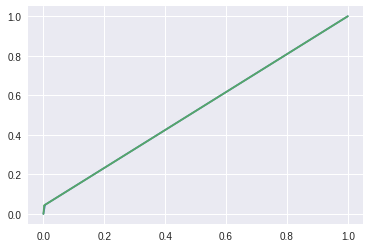

In [0]:
#@title Default title text { display-mode: "code" }
from sklearn import metrics

# Training data
df = td.read_td_query('''
  select
    *
  from
    churn_prediction_without_rescale
  where
    class like 'train'
''', engine=presto)

fig, ax = plt.subplots()
fpr, tpr, thresholds = metrics.roc_curve(df['is_churn'], df['prob'])
train_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr)

# Test data
df = td.read_td_query('''
  select
    *
  from
    churn_prediction_without_rescale
  where
    class like 'test'
''', engine=presto)

fpr, tpr, thresholds = metrics.roc_curve(df['is_churn'], df['prob'])
test_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr)

print("Train auc : {:.4f}\nTest auc : {:.4f}".format(train_auc, test_auc))
plt.show()

### Discussion

ROC indicates the model do not work well. It may be caused by not having features rescaled.  
Let's re-generate a model with rescaled feature variables.

## With rescaling

### Preprocess

In [0]:
recreate_table(c, 'churn_preprocessed_with_rescale')

#### Calculate the minimum and maximum of each columns

In [0]:
df = td.read_td_query('''
select 'account_length' as column, min(account_length) as min, max(account_length) as max from churn_dataset
union all
select 'vmail_message' as column, min(vmail_message) as min, max(vmail_message) as max from churn_dataset
union all
select 'day_calls' as column, min(day_calls) as min, max(day_calls) as max from churn_dataset
union all
select 'eve_calls' as column, min(eve_calls) as min, max(eve_calls) as max from churn_dataset
union all
select 'night_calls' as column, min(night_calls) as min, max(night_calls) as max from churn_dataset
union all
select 'intl_calls' as column, min(intl_calls) as min, max(intl_calls) as max from churn_dataset
union all
select 'cust_serv_calls' as column, min(cust_serv_calls) as min, max(cust_serv_calls) as max from churn_dataset
union all
select 'day_mins' as column, min(day_mins) as min, max(day_mins) as max from churn_dataset
union all
select 'eve_mins' as column, min(eve_mins) as min, max(eve_mins) as max from churn_dataset
union all
select 'night_mins' as column, min(night_mins) as min, max(night_mins) as max from churn_dataset
union all
select 'intl_mins' as column, min(intl_mins) as min, max(intl_mins) as max from churn_dataset
''', engine=presto)


#### Rescale with results above

In [0]:
df = td.read_td_query('''
with rescaled as (
  select
    is_churn,
    state,area_code,intl_plan,vmail_plan,    

    rescale(vmail_message, 0, 51) as vmail_message,
    rescale(intl_calls, 0, 20) as intl_calls,
    rescale(cust_serv_calls, 0, 9) as cust_serv_calls,
    rescale(eve_calls, 0, 170) as eve_calls,
    rescale(account_length, 1, 243) as account_length,
    rescale(night_calls, 33, 175) as night_calls,
    rescale(day_mins, 0, 350.8) as day_mins,
    rescale(day_calls, 0, 165) as day_calls,
    rescale(eve_mins, 0, 363.7) as eve_mins,
    rescale(intl_mins, 0, 20) as intl_mins,
    rescale(night_mins, 23.2, 395) as night_mins

  from
    churn_dataset
)

insert overwrite table churn_preprocessed_with_rescale
select
  -- add user_id
  row_number() over() as userid

  -- Convert the target variable into binary.
  ,case when is_churn like 'True.' then 1 else 0 end as is_churn
  
  -- Splits into training data and test data
  ,case when rand() < 0.8 then 'train' else 'test' end as class
  
  -- Concat categorical features adn quantitative ones. Also, `add_bias` is needed for polynomial models.
  ,add_bias(
    array_concat(

      -- same as 'Categorical features'
      categorical_features(
        array('state','area_code','intl_plan','vmail_plan'),
        state,area_code,intl_plan,vmail_plan
      )
      -- same as 'Qategorical features'
      ,quantitative_features(
        array('account_length','vmail_massage','day_calls','eve_calls','night_calls','intl_calls','cust_serv_calls','day_mins','eve_mins','night_mins','intl_mins'),
        account_length,vmail_message,day_calls,eve_calls,night_calls,intl_calls,cust_serv_calls,day_mins,eve_mins,night_mins,intl_mins
      )
    )
  ) as features
from
  rescaled
''', engine=hive)

### Build a model, again

In [0]:
recreate_table(c, 'churn_logloss_model_rescale')

In [0]:
df = td.read_td_query('''
insert overwrite table churn_logloss_model_rescale
select
  train_classifier(
    features,
    is_churn,
    '-loss_function logloss -optimizer SGD -regularization l1'
  ) as (feature, weight)
from
  churn_preprocessed_with_rescale
where
  class like 'train'
''', engine=hive)

### Prediction

In [0]:
recreate_table(c, 'churn_prediction_with_rescale')

In [0]:
df = td.read_td_query('''
with parsed as (
  select
    userid
    ,is_churn
    ,class
    ,extract_feature(feature) as feature
    ,extract_weight(feature) as value
  from
    churn_preprocessed_with_rescale
  lateral view
    explode(features) t as feature
)

insert overwrite table churn_prediction_with_rescale 
select
  userid
  ,is_churn 
  ,class
  ,sigmoid(sum(value * weight)) as prob
from
  parsed
  inner join
  churn_logloss_model_rescale model
  on
    parsed.feature = model.feature
group by
  1,2,3
''', engine=hive)

### Evaluation

Train auc : 0.8304
Test auc : 0.8508


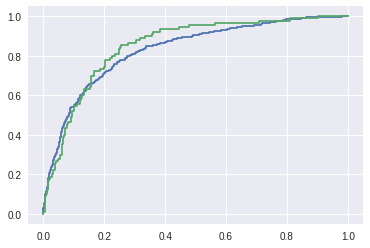

In [0]:
from sklearn import metrics

# Training data
df = td.read_td_query('''
  select
    *
  from
    churn_prediction_with_rescale
  where
    class like 'train'
''', engine=presto)

fig, ax = plt.subplots()
fpr, tpr, thresholds = metrics.roc_curve(df['is_churn'], df['prob'])
train_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr)

# Test data
df = td.read_td_query('''
  select
    *
  from
    churn_prediction_with_rescale
  where
    class like 'test'
''', engine=presto)

fpr, tpr, thresholds = metrics.roc_curve(df['is_churn'], df['prob'])
test_auc = metrics.auc(fpr, tpr)
ax.plot(fpr, tpr)

print("Train auc : {:.4f}\nTest auc : {:.4f}".format(train_auc, test_auc))
plt.show()

### Discussion

Having features rescaled, the accuracy got better.

In order to improve the accuracy, 
- add/remove features.
- aggregate existing features.
- have the number of target classes balanced.
- try other models rather than logistic regression.
- and so on.

# Appendix

## AUC of ROC

AUC of ROC is one of accuracy indications of binary classification tasks.

When probabilities are randomized, the auc of ROC is around 0.50   
and the ROC is nealy  `y = x`.

The better machine learning model works, the bigger AUC of ROC gets.  
The maximum value is 1.0.


ROC of AUC : 0.5148


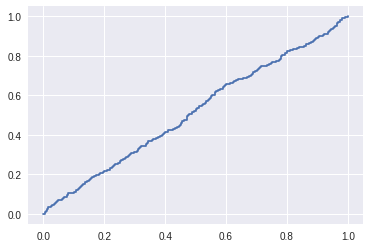

In [0]:
df = td.read_td_query('''
  select
    case when is_churn like 'True.' then 1 else 0 end as is_churn
    ,rand() as prob
  from
    churn_dataset
''', engine=presto)

# Plot ROC
fpr, tpr, thresholds = metrics.roc_curve(df['is_churn'] == 1, df['prob'])
print('ROC of AUC : {:.4f}'.format(metrics.auc(fpr, tpr)))
plt.plot(fpr, tpr)
plt.show()